# Learning Theory from First Principles

## Chapter 9 : Neural Networks

### Generic packages, settings and helper functions



#### Packages

In [ ]:
from google.colab import files
import numpy as np
from numpy.random import randn, rand
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from scipy.stats import ortho_group
from scipy.special import erfinv, gamma
from scipy.linalg import sqrtm, eigh
from bisect import bisect
import tqdm
import warnings

np.random.seed(seed=1)

#### Settings

The code below is used to standardize the appearance of the graphics. The graphs may appear unevenly sized when displayed in this notebook, but once downloaded they are the correct size.

In [ ]:
# Appearance of the graphs

# adujst font
SMALL_FONT = 5
MED_FONT = 8
BIG_FONT = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_FONT
mpl.rcParams['axes.titlesize'] = SMALL_FONT

# adujst lines and markers
mpl.rcParams['axes.linewidth'] = .3
mpl.rcParams['lines.linewidth'] = .7
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['patch.linewidth'] = .3
mpl.rcParams['errorbar.capsize'] = 1.5
mpl.rcParams['lines.markeredgewidth'] = .3

# withdraw the ticks
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0

# adjust legend box
mpl.rcParams['legend.fancybox'] = 0
mpl.rcParams['legend.shadow'] = 0
mpl.rcParams['legend.framealpha'] = 1

# adjust fig general settings
mpl.rcParams['figure.dpi'] = 600

big_rectangle = (6.5, 3.5) # height = 9 cm, width = 17 cm
medium_rectangle = (4.7, 1.6) # height = 4 cm, width = 12 cm
medium_square = (4.7, 4.7) # height = 12 cm, width = 12 cm
small_rectangle = (2.4, 1.6) # height = 6 cm, width = 4 cm
mpl.rcParams['figure.figsize'] = small_rectangle

inner_space = {'wspace':.5, 'hspace':.5}

# savefig params
mpl.rcParams["savefig.bbox"] = 'tight'

#### Helper functions

In [ ]:
def mse(y_hat, y):
  return np.mean((y - y_hat)**2)

zero_one = np.vectorize(lambda u: 1 if u<0 else 0)
hinge = np.vectorize(lambda u: np.maximum(1-u, 0))
square = np.vectorize(lambda u: (1-u)**2)
logis = np.vectorize(lambda u: np.log(1+np.exp(-u)))

### Figures

#### Fig 9.1

In [ ]:
def launch_training_relu_nn(X, y, Xtest, ytest, m, batch_size, maxiter, gamma):
    n, d = X.shape
    ntest, d = Xtest.shape

    # random on the sphere
    w = np.random.randn(d, m) / np.sqrt(d / 2)
    w = np.random.randn(d, m)
    w = w / np.tile(np.sqrt(np.sum(w**2, axis=0)),(d,1))
    b = np.random.rand(1, m) * 2 - 1
    eta = np.random.randn(1, m) / np.sqrt(m / 2)
    eta_bias = 0

    # training
    train_errors = np.zeros(maxiter // 100)
    test_errors = np.zeros(maxiter // 100)

    for iter in range(maxiter):
        if (iter+1) % 100 == 1:
            test_errors[iter // 100] = np.mean((np.maximum(Xtest @ w + np.tile(b, (ntest,1)), 0) @ (eta.T) + eta_bias - ytest) ** 2)

        ind = (iter * batch_size + np.arange(batch_size)) % n
        Xbatch = X[ind,:]
        ybatch = y[ind]
        hidden = np.maximum(Xbatch @ w + np.tile(b, (batch_size,1)), 0)
        hiddender = ((Xbatch @w + np.tile(b, (batch_size, 1))) > 0)*1
        ypred = hidden@(eta.T) + eta_bias
        if (iter+1) % 100 == 1:
            train_errors[iter // 100] = np.mean((ypred - ybatch) ** 2)

        gradeta = (ypred - ybatch).T.dot(hidden)
        # gradeta_bias = np.sum(ypred - ybatch)
        gradb = (ypred - ybatch).T @ (hiddender * np.tile(eta, (batch_size,1)))
        gradw = Xbatch.T @ ((ypred - ybatch) * (hiddender * np.tile(eta, (batch_size,1))))

        w -= (gamma / batch_size) * gradw
        b -= (gamma / batch_size) * gradb
        eta -= (gamma / batch_size) * gradeta

    return w, b, eta, eta_bias, test_errors, train_errors

#### Fig 9.2

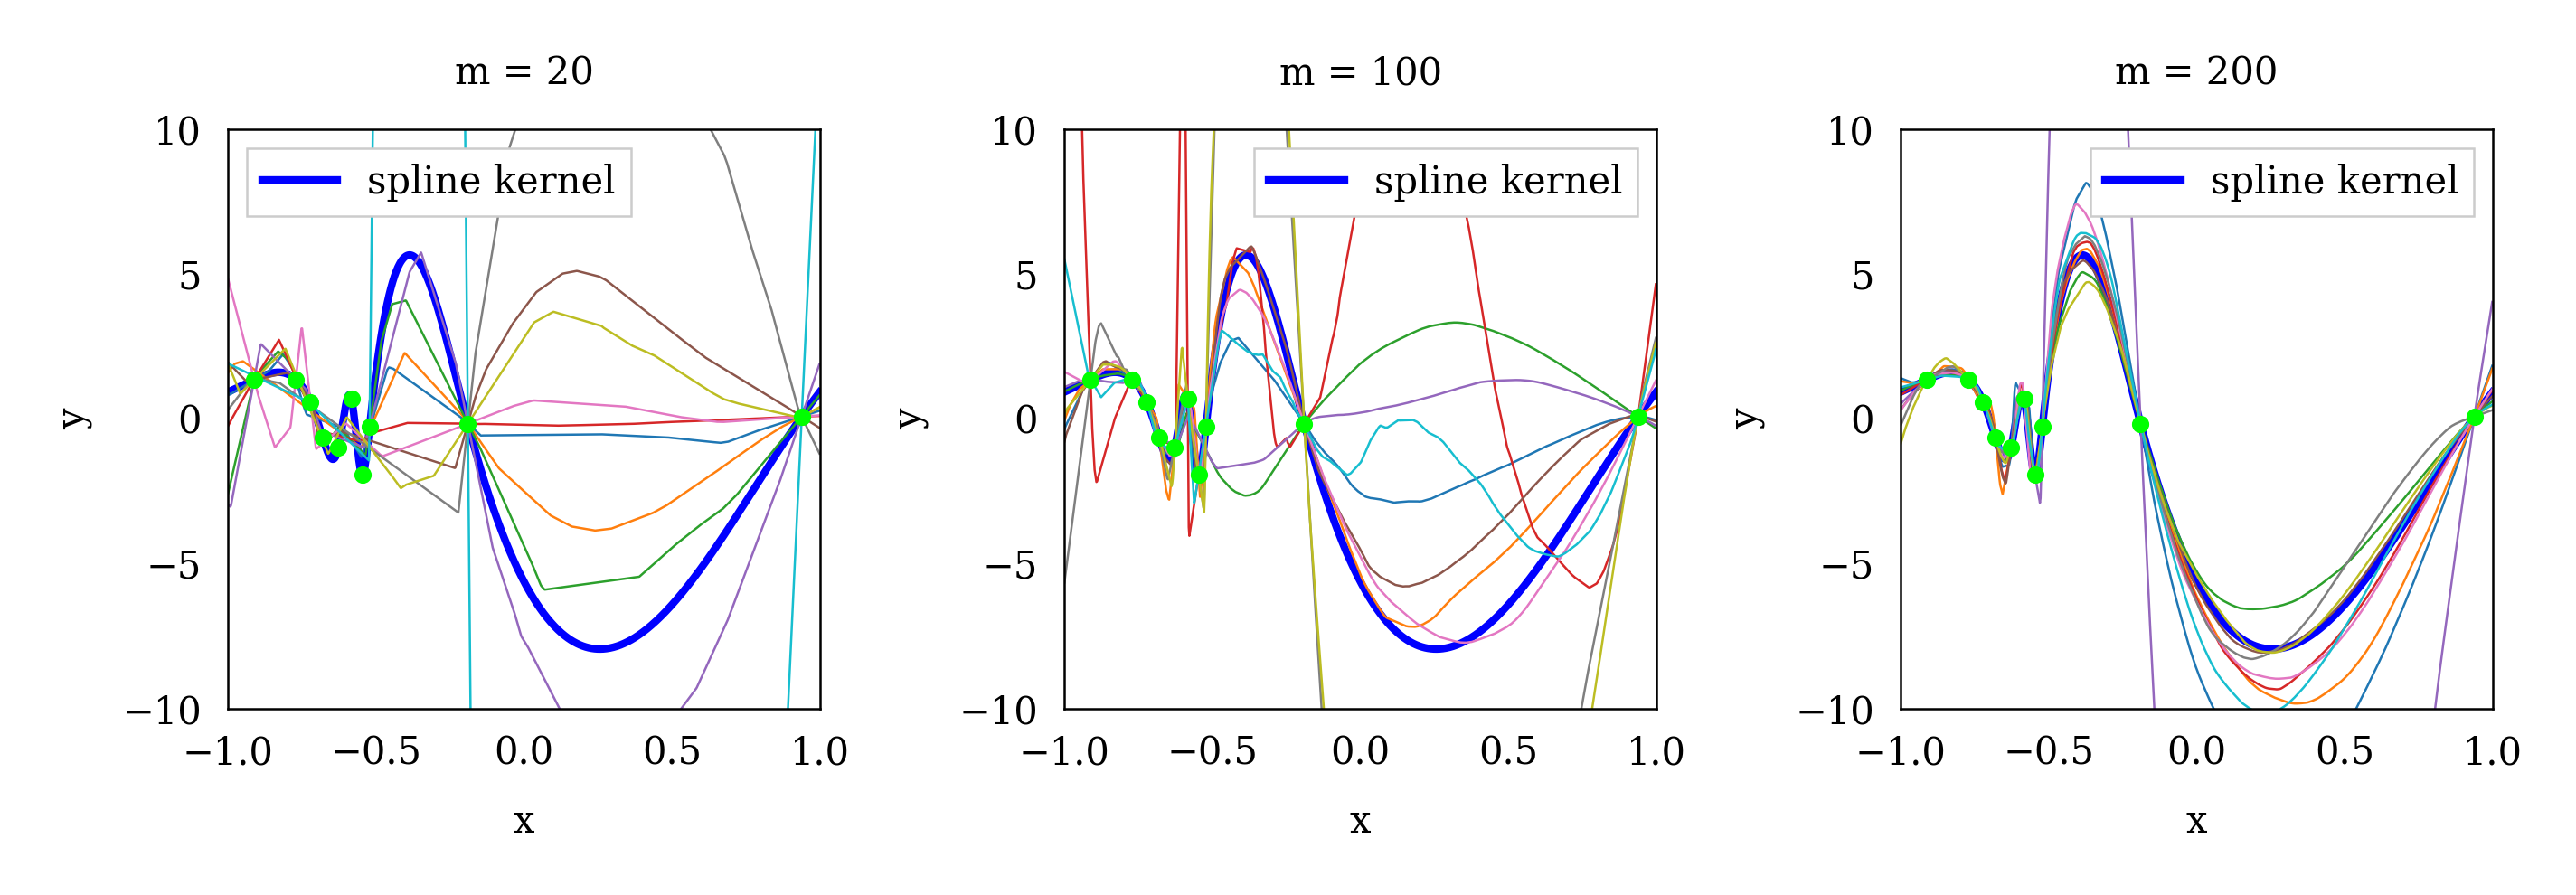

In [ ]:
def distmat(a,b):
    a = a.reshape(-1)
    b = b.reshape(-1)
    C = ((a[:,None]-b[None,:])**2)
    # C = np.sum(a**2,0)[:,None] + np.sum(b**2,0)[None,:] - 2*a.transpose().dot(b)
    return C

def Kernel(X, X_, d):
    return 1/6 + X.dot(X_.T)/2/d + distmat(X.T, X_.T)**(1.5)/24 * gamma(2)*gamma(d/2) / gamma(d/2+3/2) / gamma(1/2)

d = 1
n = 10
x = np.random.rand(n,1)*2 - 1
y = np.abs(x) - 1 + randn(n,1)*0.1
y = randn(n,1)
xtest = (2*np.arange(0, 1.0, 0.001)-1).reshape(-1,1)
ntest = len(xtest)

alphak = 6
K = Kernel(x,x, d)
Ktest = Kernel(xtest,x, d)
alpha = np.linalg.lstsq(K, y, rcond=None)[0]
yest1 = Ktest.dot(alpha)

M = [20, 100, 200]
nrep = 10
yests = np.zeros((len(M), len(xtest), nrep))
for mrep in range(len(M)):
    for irep in range(nrep):
        m = M[mrep]
        W = randn(m,d);
        W = W / np.sqrt(np.sum(W**2, 1))[:,None]
        b = rand(m,1)*2-1
        Phi = np.maximum(x.dot(W.T) + b.T, 0)
        Phitest = np.maximum(xtest.dot(W.T)+b.T, 0)
        K = Phi.dot(Phi.T)/m
        Ktest = Phitest.dot(Phi.T)/m
        alpha = np.linalg.lstsq( (K + 1e-12*np.eye(n)), y, rcond=None)[0]
        yests[mrep, :, irep] = Ktest.dot(alpha).reshape(-1)

plt.figure(figsize=medium_rectangle, tight_layout=True)

for i in range(len(M)):
    m = M[i]
    plt.subplot(1,3,i+1)
    plt.plot(xtest, yest1, 'b', linewidth=1, label='spline kernel')
    plt.plot(xtest, yests[i], linewidth=.3)
    plt.plot(x, y, '.', c = 'lime', markersize = 4)
    plt.xlim(-1, 1)
    plt.ylim(-10, 10)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'm = {m}')
    plt.legend();

plt.savefig('fig92.svg')
files.download("fig92.svg")

#### Fig 9.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

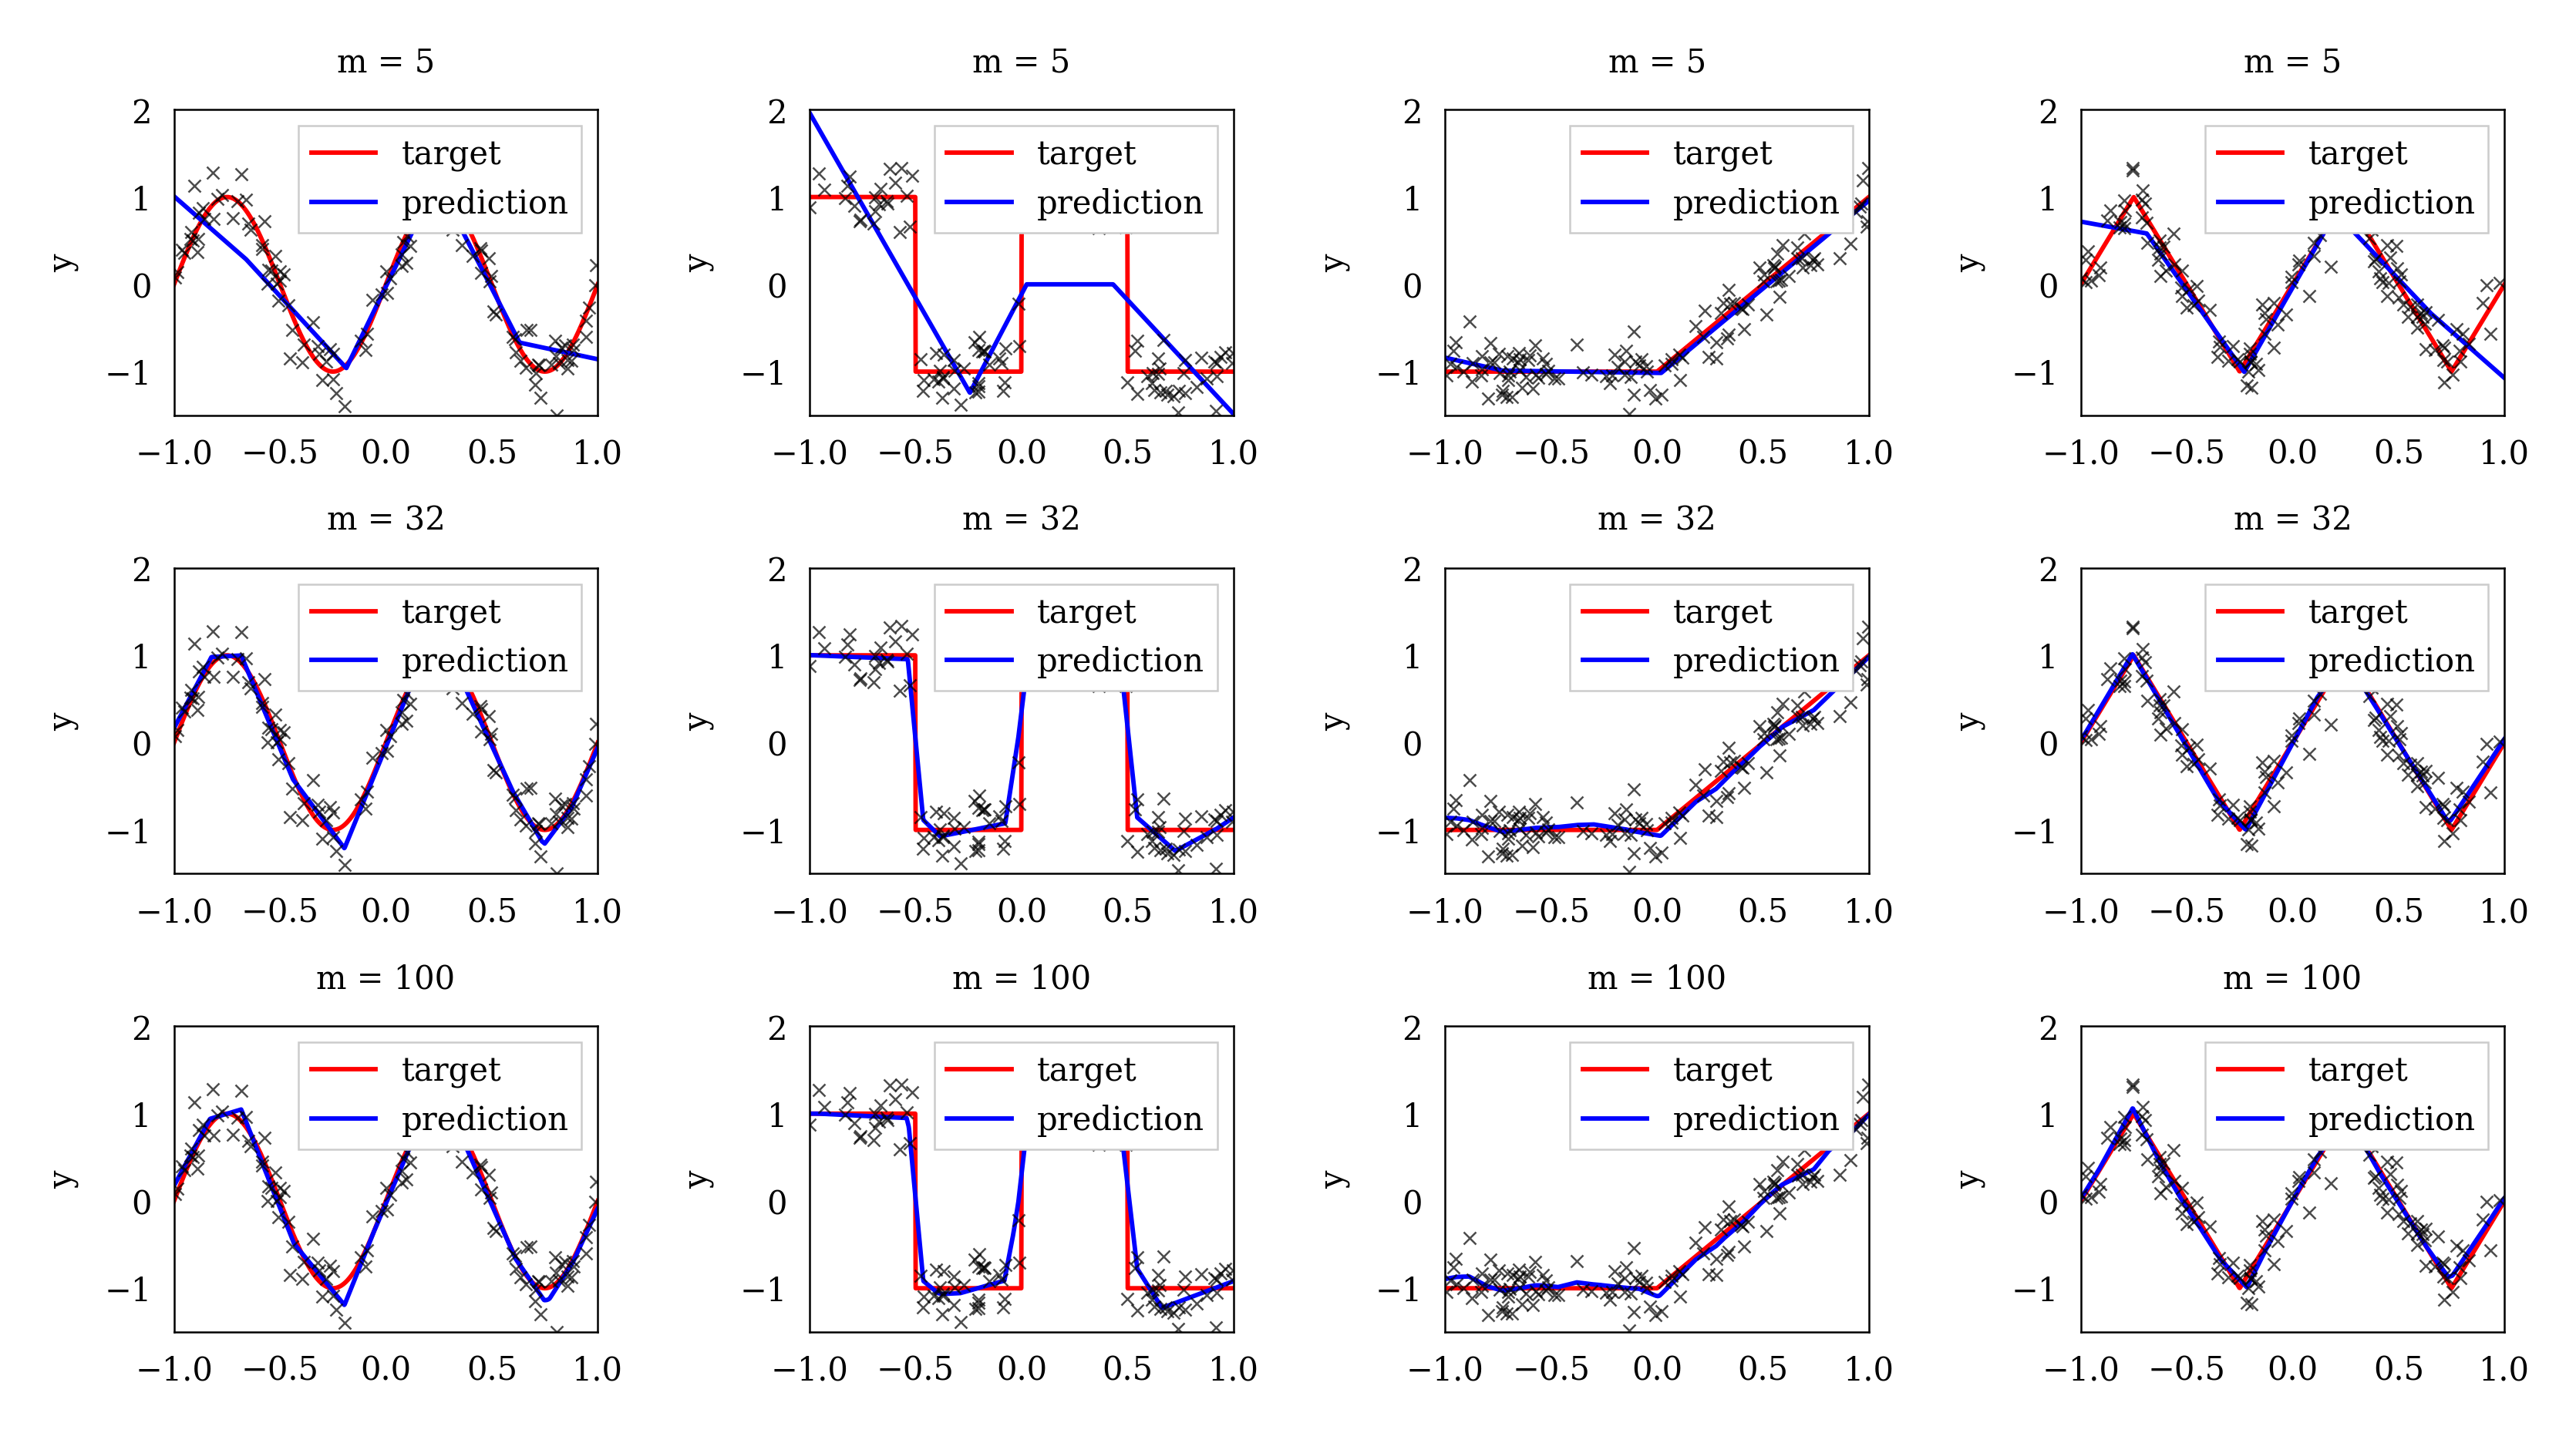

In [ ]:
n = 128
ntest = 1024
nrep = 1

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=big_rectangle, gridspec_kw = inner_space)

for idata in range(1,5):
    X = np.random.rand(n)*2-1
    Xtest = np.linspace(-1,1,ntest).T
    std_noise = .2

    if idata == 1:
        y = np.sin(2 * np.pi * X) + std_noise * np.random.randn(n)
        ytest = np.sin(2 * np.pi * Xtest)
    elif idata == 2:
        y = np.sign(np.sin(2 * np.pi * X)) + std_noise * np.random.randn(n)
        ytest = np.sign(np.sin(2 * np.pi * Xtest))
    elif idata == 3:
        y = ((np.maximum(X/2, 0) - 0.25) * 4) + std_noise * np.random.randn(n)
        ytest = (np.maximum(Xtest/2, 0) - 0.25) * 4
    elif idata == 4:
        y = (4 * np.abs(X + 1 - 0.25 - np.floor(X + 1 - 0.25) - 1/2) - 1) + std_noise * np.random.randn(n)
        ytest = 4 * np.abs(Xtest + 1 - 0.25 - np.floor(Xtest + 1 - 0.25) - 1/2) - 1

    ms = [5, 32, 100]
    for im, m in enumerate(ms):
        maxiter = 400000
        gamma = 0.005
        batch_size = 16

        # Training
        w, b, eta, eta_bias, test_errors, train_errors = launch_training_relu_nn(X.reshape(n,1), y.reshape(n,1), Xtest.reshape(ntest,1), ytest.reshape(ntest,1), m, batch_size, maxiter, gamma)

        # Testing
        ytest_pred = np.maximum(Xtest.reshape(ntest,1)@w + np.tile(b, (ntest,1)), 0) @ eta.T + eta_bias

        plt.sca(axs[im, idata-1])
        plt.plot(Xtest, ytest, 'r')
        plt.plot(Xtest, ytest_pred, 'b')
        plt.plot(X, y, 'kx', alpha=0.7)
        plt.legend(['target', 'prediction'], loc='upper right')
        plt.ylabel('y')
        plt.xlim([-1,1])
        plt.ylim([-1.5,2])
        plt.title(f'm = {m}')

plt.savefig('fig93.svg')
files.download("fig93.svg")

plt.show()